# 以DQN实作木棒台车
### 程式修改自

[Reinforcement Learning (DQN) Tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
=====================================
**Author**: `Adam Paszke <https://github.com/apaszke>`

## 载入套件

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from IPython import display

## 设定环境

In [1]:
# 图表直接嵌入到 Notebook 之中
%matplotlib inline

# 采 non-block 模式，即 plt.show 不会暂停
plt.ion()

# 判断是否使用 gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 载入木棒台车游戏

In [ ]:
env = gym.make('CartPole-v0').unwrapped

## Experience Replay Memory 机制

In [3]:
# 定义训练资料栏位
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# 定义 Experience Replay Memory 机制
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Bellman Q值公式：
$\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}$

## 时序差分公式(temporal difference error)：
$\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}$

## [Huber loss](https://en.wikipedia.org/wiki/Huber_loss)：

$\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}$

$\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}$

## 定义卷积神经网路模型

In [1]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # 计算 Linear 神经层输入个数
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

NameError: name 'nn' is not defined

## 定义相关函数

In [ ]:
# 影像转换为张量
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

# 取得台车在荧幕的位置
def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0) 

# 取得荧幕所有像素，并转换为张量
def get_screen():
    # 将荧幕像素格式转为三维张量：颜色、高度、宽度(CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    
    # 台车影像只占荧幕下半部，故只撷取下半部像素
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    screen = screen[:, :, slice_range]
    
    # 部分取值(slicing)后，阵列会变成不连续的储存，使用下列指令，改为连续
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # 加一维度 (BCHW)
    return resize(screen).unsqueeze(0)

# 重置游戏
env.reset()

## 测试画面显示

C:\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
C:\anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:434: UserWarning: [WinError -2147417850] 执行绪模式设定后就不能再变更它。
  warnings.warn(str(err))


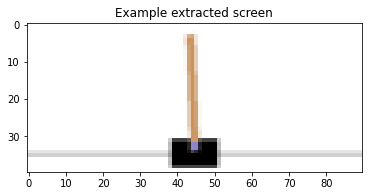

In [5]:
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

## 超参数设定

In [10]:
BATCH_SIZE = 128    # 批量
GAMMA = 0.999       # 折扣率
EPS_START = 0.9     # ε greedy策略随机的初始比例
EPS_END = 0.05      # ε greedy策略随机的最小比例
EPS_DECAY = 200     # 随机的衰退比例 
TARGET_UPDATE = 10  # 更新Q值的频率

# 取得荧幕宽高
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# 取得行动类别的个数
n_actions = env.action_space.n

# 定义2个网路
policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# 定义优化器
optimizer = optim.RMSprop(policy_net.parameters())

# 定义伫列及容量
memory = ReplayMemory(10000)

# 初始化变数
steps_done = 0         # 完成的步骤个数
episode_durations = [] # 每回合的游戏时间

# 行动选择
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1)：取得每一列最大值
            # [1]：取得索引值
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], 
                            device=device, dtype=torch.long)

# 绘制游戏时间的线图
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 每 100 回合取平均值绘图
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 暂停，让画面更新
    display.clear_output(wait=True) # 清画面
    display.display(plt.gcf())      # 得到当前的figure并显示

## 定义神经网路训练函数

In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE: # 累积够资料才训练
        return
    transitions = memory.sample(BATCH_SIZE) # 随机抽样
    batch = Transition(*zip(*transitions))  # 转换为输入格式

    # 生成 next_states 栏位
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                      batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # 计算 Q(s_t, a)、选择行动
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 更新 Q 值
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states
                                                ).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # 计算 Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # 反向传导
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

## 模型训练

In [ ]:
num_episodes = 300  # 训练 300 回合
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen # 目前画面像素与上一时间点之差
    for t in count(): # 生成连续的变数值，即 0, 1, 2, ...
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # 取得状态(荧幕像素)
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # 存入伫列
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # 训练
        optimize_model()
        if done:
            episode_durations.append(t + 1) # 记录每一回合的步数
            #plot_durations()
            break
            
    # 复制权值至Target网路
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

## 绘制训练过程

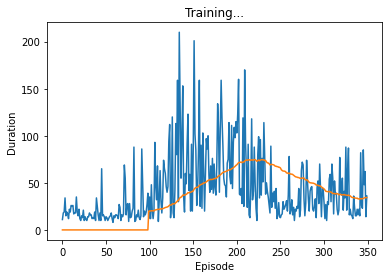

<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>

In [13]:
plot_durations()  # 绘制训练过程
print('Complete')
env.render()  # 渲染画面
env.close()   # 结束游戏
plt.ioff()    # 恢复 Blocked 绘图模式
plt.show();   # 显示图形

Here is the diagram that illustrates the overall resulting data flow.

.. figure:: /_static/img/reinforcement_learning_diagram.jpg

Actions are chosen either randomly or based on a policy, getting the next
step sample from the gym environment. We record the results in the
replay memory and also run optimization step on every iteration.
Optimization picks a random batch from the replay memory to do training of the
new policy. "Older" target_net is also used in optimization to compute the
expected Q values; it is updated occasionally to keep it current.


